macros latex
$$ 
\def\R{{\mathbb R}} 
\def\x{{\bf x}}
\def\y{{\bf y}}
\def\a{{\bf a}}
\def\w{{\bf w}}
$$

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn as sk
from sklearn.linear_model import LinearRegression
import sklearn.datasets

# Perceptron : modèle et algorithme

## Classification
Un **problème de classification** est un problème d'apprentissage supervisé où les étiquettes cibles à prédire sont prennent des valeurs binaires. Dans un problème de **classificiation binaire** il n'y a que deux classes et on peut supposer les données de la forme
$${\cal D} = \{ (x^i,y^i) \}_{1 \leq i \leq m}$$
avec $x^i \in \R^d$ et $y^i \in \{-1, +1 \}$  
(on peut parfois aussi considérer les classes $1$ et $0$ au lieu de $1$ et $-1$).

### Exemple en dimension 1  
On cherche à prédire la race d'un chien suivant sa masse.  
Classe -1 : Caniche (12kg en moyenne)
Classe 1 : Dobermann (42 kg en moyenne)

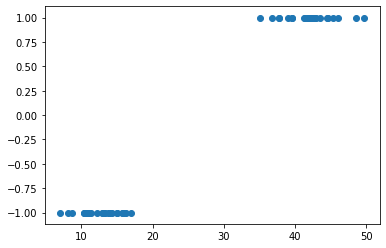

In [23]:
can = np.random.normal(12,3,25)
dob = np.random.normal(42,4,25)
X = np.concatenate((can, dob))
Y = np.array([-1]*25 + [1]*25)
plt.scatter(X,Y)
plt.show()

Essayons de classifier avec la régression linéaire

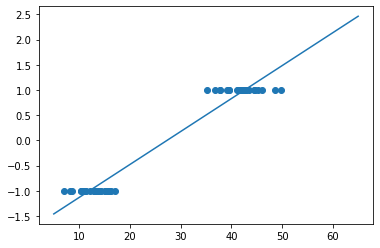

In [24]:
Xr = X.reshape(-1,1)
lin_reg = LinearRegression()
lin_reg.fit(Xr,Y)
Xlin = np.linspace(5,65,200)
plt.plot(Xlin,lin_reg.predict(Xlin.reshape(-1,1)))
plt.scatter(X,Y)
plt.show()

On voit que la regression linéaire en dimension 1 n'est pas du tout adaptée pour séparer les classes. 

### Exemples en dimension 2

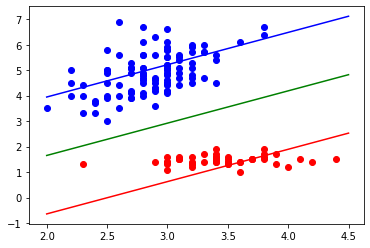

In [87]:
iris = sk.datasets.load_iris()
X = iris.data[ :, 1:3]
Y0 = iris.target
rename = lambda x : 1 if x == 0 else -1
rename = np.vectorize(rename)
Y = rename(Y0)
plt.scatter(X[Y==1][:,0],X[Y==1][:,1],c='red')
plt.scatter(X[Y==-1][:,0],X[Y==-1][:,1],c='blue')
lin_reg.fit(X,Y)
Xlin = np.linspace(2,4.5,200)
a1,b1 = lin_reg.coef_  
c = lin_reg.intercept_
plt.plot(Xlin, -c/b1 - a1/b1*Xlin , c='green')       #a1 x + b1 y + c = 0 
plt.plot(Xlin, (1-c)/b1 - a1/b1*Xlin , c= 'red')    #a1 x + b1 y + c = 1 
plt.plot(Xlin, (-1-c)/b1 - a1/b1*Xlin, c='blue' )   #a1 x + b1 y + c = -1 
plt.show()

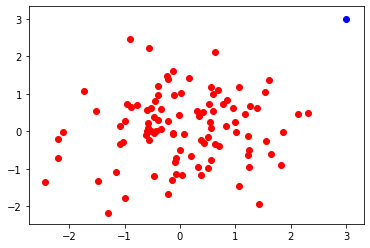

In [118]:
X1 = np.random.multivariate_normal([0,0],[[1,0],[0,1]],100)
X1 = np.concatenate( (X1, np.array([[3,3]])), axis=0 )
Y1 = np.array([1]*100 + [-1])
plt.scatter(X1[Y1==1][:,0],X1[Y1==1][:,1],c='red')
plt.scatter(X1[Y1==-1][:,0],X1[Y1==-1][:,1],c='blue')
plt.show()

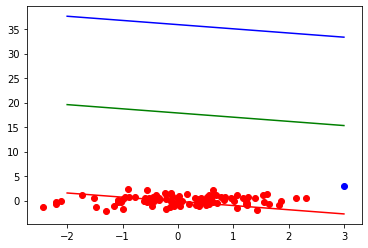

In [120]:
lin_reg.fit(X1,Y1)
Xlin = np.linspace(-2,3,200)
a1,b1 = lin_reg.coef_  
c = lin_reg.intercept_
plt.scatter(X1[Y1==1][:,0],X1[Y1==1][:,1],c='red')
plt.scatter(X1[Y1==-1][:,0],X1[Y1==-1][:,1],c='blue')
plt.plot(Xlin, -c/b1 - a1/b1*Xlin , c='green')       #a1 x + b1 y + c = 0 
plt.plot(Xlin, (1-c)/b1 - a1/b1*Xlin , c= 'red')    #a1 x + b1 y + c = 1 
plt.plot(Xlin, (-1-c)/b1 - a1/b1*Xlin, c='blue' )   #a1 x + b1 y + c = -1
plt.show()

Bilan : la regression linéaire n'est pas pas du tout adaptée à la classification, même pour les données qui sont pourtant *linéairement séparables*.

## Modèle du perceptron, un classificateur linéaire

L'algorithme du Perceptron (Rosenblatt 1957) est un algorithme de *classification linéaire* qui est un modèle élémentaire de neurone.

<img src="images/neurone_bio.png" width=500 alt="neurone biologique">


<img src="images/neurone_bio.png" width=200 alt="neurone biologique">
<img src="images/neurone_art.png" width=500 alt="neurone artificiel">

Le perceptron est un modèle (et un algorithme) pour la classification. On a des données de la forme $(x^i,y^i)$ pour $i$ de 1 à $m$ où $y^i \in \{+1, -1\} $ est l'image de $x^i \in \R^d$ par une fonction inconnue que l'on cherche à approximer.  
Les données appartiennent donc à deux *classes* notées $+1$ et $-1$ et le perceptron doit apprendre à prédire cette classe $y^i$ en fonction de $x^i$.

Le modèle du perceptron, comme la régression linéaire, est *paramétrique*. Les *hypothèses* sont les fonctions
$$h_\w : \R^d \rightarrow \{+1,-1\}$$
  
  où $\w$ est un *vecteur de poids* (paramètres) $\w=(w_1,w_2,\dots,w_d) \in \R^d$ et biais $b \in \R$

  On prédit

  $h(\x) = 1$ si $\sum_{i=1}^d w_i x_i + b \geq 0$
  
  $h(\x) = -1$ si $\sum_{i=1}^d w_i x_i + b < 0$

soit 
  $$h(\x) = \text{signe}(\langle \x,\w \rangle + b) $$




<img src="images/percep1.png" width=500 alt="separation plan par perceptron">

Comme dans le cas de la régression, on augmente la dimension des données avec une coordonnée $x^i_0 = 1$ et on pose $w_0 = b$ de sorte de se ramener à une expression linéaire :
$$h(\x) = \text{signe}(\sum_{i=1}^n w_i x_i + b) = \text{signe}(\sum_{i=0}^n w_i x_i ) $$


On dit que l'échantillon ${\cal D} = \{ (x^i,y^i)_{1 \leq i \leq m}\} $ est *linéairement séparable* s'il existe un hyperplan séparant les deux classes $1$ et $-1$, autrement dit s'il existe $\w$ et $b$ tels que $g_\w(x^i) = y^i$.

In [6]:
X0=np.array([[1,-1],[3,2],[1,3],[-1,1],[1,5],[-1,4],[-2,2]])
Y0=np.array([-1,-1,-1,-1,1,1,1])

def visualiser_points(X,Y):
        """représente les points de l'échantillon et leur classe en deux couleurs
        """
        plt.scatter(x=X[Y == 1, 0], y=X[Y == 1, 1], c='green', marker='o', edgecolor='black')
        plt.scatter(x=X[Y == -1, 0], y=X[Y == -1, 1], c='red', marker='o', edgecolor='black')
        plt.show()

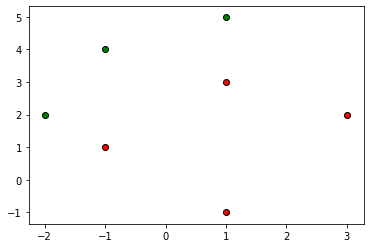

In [7]:
visualiser_points(X0,Y0)

*  initialiser $\w = \mathbf{0} = (0,0,\dots,0)$
*  Tant qu'il existe au moins un point $\x^i$, $1 \leq i \leq m$
  qui n'est pas classifié correctement i.e.
  $$h_\w(x_i) \neq y_i$$ 
  * choisir un tel $\x^i$ mal classifié
  * mettre à jour
  $$\w \leftarrow \w + y^i \cdot \x^i$$



  Si $\x^i$ est mal classifié, $y^i \neq h(\x^i)$ soit $y^i \cdot \langle
  \x^i,\w \rangle < 0$

  Le nouveau $\w'= \w + y^i \cdot \x^i$ est donc tel que


  \begin{align*}
    h'(\x^i) &= \langle \w',\x^i \rangle \\
    &= \langle \w  + y^i \cdot \x^i ,\x^i \rangle \\
    &= \langle \w,\x^i  \rangle + y^i \langle \x^i,\x^i \rangle  \\
    &= h(\x^i) + y^i \cdot \|\x^i\|^2   \\
  \end{align*} 

  va donc faire évoluer la classification de $\x^i$ dans le sens souhaité

  ex : si $y^i = 1$ et qu'on avait $h(\x^i) <0$ (mauvaise classification)
  on voit que $h(\x^i)$ va augmenter


  **Théorème** Si l'échantillon $(\x^1,\x^2,\cdots,\x^m)$ est linéairement séparable,
    alors en un nombre fini d'étapes l'algorithme du perceptron va se terminer.  
  
  Le résultat final obtenu dépend de l'ordre dans lequel les points mal
  classifiés   sont considérés.

In [13]:
class Perceptron:
    
    def __init__(self):
        self.w = None #vecteur de poids, w[0] contient le biais
        
    def prediction(self,x):
        """une fois le perceptron entraîné, prédit la valeur sur un point"""
        return 1 if (self.w[0] + np.dot(self.w[1:],x) >=0) else -1
    
    def entrainement(self, X, Y, nb_etapes = None, rapport = False):
        """X est un jeu de données d-dimensionnelles (np.arrays)
        Y est l'ensemble des valeurs +1/-1 correspondantes
        Y[i] est la classe de X[i]
        L'algorithme du perceptron va tourner au maximum
        sur le nombre d'étapes données jusqu'à convervence"""
        
        etape = 0 # compteur d'étapes
        en_cours = True
        
        if nb_etapes == None:
            nb_etapes = 10000 # sécurité

        #initialisation des poids à 0
        self.w = np.array([0]*(1+len(X[0])),dtype=float)
            
        while en_cours and etape < nb_etapes:
            #recherche du premier point mal classifié
            i = 0
            while i< len(X) and self.prediction(X[i]) == Y[i]:
                #le point est bien classé
                i += 1
            
            if i==len(X):
                #tous les points sont bien classifiés 
                en_cours = False
                break
            else:
                #X[i] est mal classifié
                
                self.w[0] += Y[i]
                self.w[1:] += Y[i]*X[i]
            etape += 1
        if rapport:
            if etape < nb_etapes:
                print("Nombre d'étapes pour convergence :", etapes)
            else:
                print("pas de convergence")

    def visualisation(self,X,Y,label= "", transformation = None):
        """représente les points de l'échantillon et les
        zones de décision suivant la valeur actuelle de w """
        
        #on récupère les coordoonées minimales et maximales présentes
        #dans X sur les axes x1 et x2
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        
        #on crée une liste de points qui maillent tout le rectangle
        #defini par les valeurs min et max obtenues
        resolution = 0.1
        abscisses = np.arange(x1_min, x1_max, resolution)
        ordonnees = np.arange(x2_min, x2_max, resolution)
        abs_grille, ord_grille = np.meshgrid(abscisses,ordonnees)
        points = np.array([abs_grille.ravel(), ord_grille.ravel()]).T
        if transformation:
            points = transformation(points)
        #valeurs de classification associées à chaque point
        val_points = np.array([self.prediction(p) for p in points])
        
        #on place les points X de X dans le graphique
        plt.xlim(abs_grille.min(), abs_grille.max())
        plt.ylim(ord_grille.min(), ord_grille.max())
        
        cmap = ListedColormap(['tomato','lightgreen'])
        plt.contourf(abs_grille,ord_grille, val_points.reshape(abs_grille.shape), \
                     cmap=cmap, alpha=1)
        
        plt.scatter(x=X[Y == 1, 0], y=X[Y == 1, 1],
            alpha=1, c='green',
            marker='o', edgecolor='black')
        
        plt.scatter(x=X[Y == -1, 0], y=X[Y == -1, 1],
            alpha=1, c='red',
            marker='o', edgecolor='black')
        plt.title("vert=1, rouge=-1 "+ label)
        
        plt.show()
        
    def taux_erreur(self, X_test, Y_test):
        """renvoie le taux entre 0 et 1 d'erreurs du perceptron
        sur (X_test,Y_test)"""
    
        err = 0
        for i in range(len(X_test)):
            if self.prediction(X_test[i]) != Y_test[i]:
                err += 1
        return float(err)/len(X_test)  
        
    def meilleur_entrainement(self, X, Y, nb_etapes = 1000):
        """idem que entrainement mais garde en mémoire les diffents
        w obtenus et garde au final celui qui a le taux d'erreur
        le plus bas"""
                
        etape = 0 # compteur d'étapes
        en_cours = True
        

        #initialisation des poids à 0
        self.w = np.array([0]*(1+len(X[0])),dtype=float)
        Ws = [np.copy(self.w)]  #va stocker tous les w successifs
        erreurs = [self.taux_erreur(X, Y)]
                    
        while en_cours and etape < nb_etapes:
            #recherche du premier point mal classifié
            i = 0
            while i< len(X) and self.prediction(X[i]) == Y[i]:
                #le point est bien classé
                i += 1
            
            if i==len(X):
                #tous les points sont bien classifiés 
                en_cours = False
                break
            else:
                #X[i] est mal classifié
                
                self.w[0] += Y[i]
                self.w[1:] += Y[i]*X[i]
                
                Ws.append(np.copy(self.w))  #va stocker tous les w successifs
                erreurs.append(self.taux_erreur(X, Y))
            etape += 1
        i = np.array(erreurs).argmin()
        self.w = Ws[i]
    
    

In [16]:
p = Perceptron()
p.entrainement(X0,Y0)
print(p.w)

[-8. -4.  3.]


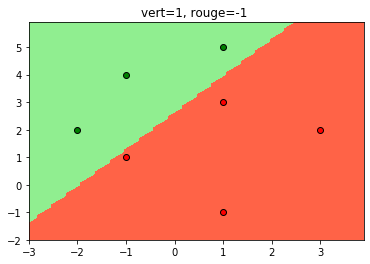

In [15]:
p.visualisation(X0,Y0)

On mesure le taux d'erreur du perceptron

## Preuve de convergence de l'algorithme